In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
np.random.seed(1)
X1 = np.random.normal(10, 2, 500)
X2 = np.random.normal(10, 10, 500)
y = 2 * (np.cos(0.05 * X1**2) + 0.1 * X1) + np.random.normal(0, 1, 500)
data = pd.DataFrame({'y': y, 'X1': X1, 'X2': X2})

In [3]:
train, test = train_test_split(data, test_size=0.2, random_state=1)

In [4]:
model = RandomForestRegressor(n_estimators=1000, random_state=1)
model.fit(train[['X1', 'X2']], train['y'])

RandomForestRegressor(n_estimators=1000, random_state=1)

In [5]:
test['y_hat'] = model.predict(test[['X1', 'X2']])

In [6]:
def true_function(x):
    return 2 * (np.cos(0.05 * x**2) + 0.1 * x)

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(test['X1'], test['y_hat'], label='Predicted', color = 'gray')
x_vals = np.linspace(test['X1'].min(), test['X1'].max(), 100)
plt.plot(x_vals, true_function(x_vals), color='red', label='True Function')
plt.xlabel('X1')
plt.ylabel('Predicted Value')
plt.legend()
plt.title("A")
plt.savefig(f"results/rf_fit.png") 
plt.close() 

In [8]:
def piecewise_function(x, x1, x2, x3, x4, y1, k1, k2, k3, k4, k5):
    conds = [
        x < x1,
        (x >= x1) & (x < x2),
        (x >= x2) & (x < x3),
        (x >= x3) & (x < x4),
        x >= x4,
    ]
    funcs = [
        lambda x: k1 * (x - x1) + y1,
        lambda x: k2 * (x - x1) + y1,
        lambda x: k3 * (x - x2) + k2 * (x2 - x1) + y1,
        lambda x: k4 * (x - x3) + k3 * (x3 - x2) + k2 * (x2 - x1) + y1,
        lambda x: k5 * (x - x4) + k4 * (x4 - x3) + k3 * (x3 - x2) + k2 * (x2 - x1) + y1,
    ]
    return np.piecewise(x, conds, funcs)

In [9]:
p0 = [ 8, 9.1, 11.8, 13.4, 14, 0.3, -2.3, 4.25, -4.5, 2.75]
params, _ = optimize.curve_fit(
    lambda x, x1, x2, x3, x4, y1, k1, k2, k3, k4, k5: piecewise_function(
        x, x1, x2, x3, x4, y1, k1, k2, k3, k4, k5
    ),
    test['X1'].values,
    test['y_hat'].values,
    p0
)


In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(test['X1'], test['y_hat'], label='Predicted',color = 'gray')
plt.plot(x_vals, piecewise_function(x_vals, *params), color='red', label='Piecewise Linear')
plt.xlabel('X1')
plt.ylabel('Predicted Value')
plt.legend()
plt.title("B")
plt.savefig(f"results/piecewise_linear.png") 
plt.close() 

In [11]:
instance = test.iloc[6]
instance

y         1.896336
X1       12.246824
X2        4.308513
y_hat     2.771087
Name: 310, dtype: float64

In [12]:
instance_features = instance[['X1', 'X2']].values.reshape(1, -1)
instance_target = instance['y_hat']

In [13]:
kernel_widths = [0.01, 0.1, 0.3, 0.5, 0.75, 1, 2]
results = {}

In [14]:
for kernel_width in kernel_widths:
    explainer = LimeTabularExplainer(
        train[['X1', 'X2']].values,
        mode="regression",
        feature_names=['X1', 'X2'],
        verbose=True,
        discretize_continuous=False,
        kernel_width=kernel_width
    )
    
    exp = explainer.explain_instance(
        instance_features.flatten(),
        model.predict,
        num_features=2
    )
    
    slope = exp.local_exp[1][0][1]
    y0 = exp.local_pred[0]
    results[kernel_width] = (slope, y0)  
##an interesting point,  the intercept belongs to the x1 = 0 of the perturbed data, not the true x1 = 0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.7711216341102936
Prediction_local [2.77111945]
Right: 2.77108725429602


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 3.6771006257011467
Prediction_local [2.9247487]
Right: 2.77108725429602


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 5.789130730924727
Prediction_local [2.92389048]
Right: 2.77108725429602


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 4.475716741417296
Prediction_local [2.92694585]
Right: 2.77108725429602


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 3.2497562578309553
Prediction_local [2.99514691]
Right: 2.77108725429602


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.6842409923605377
Prediction_local [3.09271175]
Right: 2.77108725429602


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.1596425251060882
Prediction_local [3.29005576]
Right: 2.77108725429602


In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(test['X1'], test['y_hat'],color = 'gray')
plt.scatter(
    instance['X1'], instance_target,
    color='red', s=100, label='Instance Point', edgecolor='black'
)

x_vals = np.linspace(4.5, 15, 500)
for kernel_width, (slope, y0) in results.items():
    y_vals = slope * (x_vals - instance['X1']) + y0
    plt.plot(x_vals, y_vals, linewidth=2, label=f'kernel width = {kernel_width}')

plt.ylim([-2, 5])
plt.xlabel('X1')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title("C")
plt.savefig(f"results/negative slope.png")
plt.close() 


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 3.538323650992715
Prediction_local [3.53832232]
Right: 3.554225882714026


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.978919726422002
Prediction_local [3.5307114]
Right: 3.554225882714026


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.7591000671174584
Prediction_local [3.35795647]
Right: 3.554225882714026


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.5895186261263605
Prediction_local [3.09413816]
Right: 3.554225882714026


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.382342575629979
Prediction_local [2.79441256]
Right: 3.554225882714026


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.2854394916917844
Prediction_local [2.64762469]
Right: 3.554225882714026


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.1118681606677328
Prediction_local [2.39002647]
Right: 3.554225882714026


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

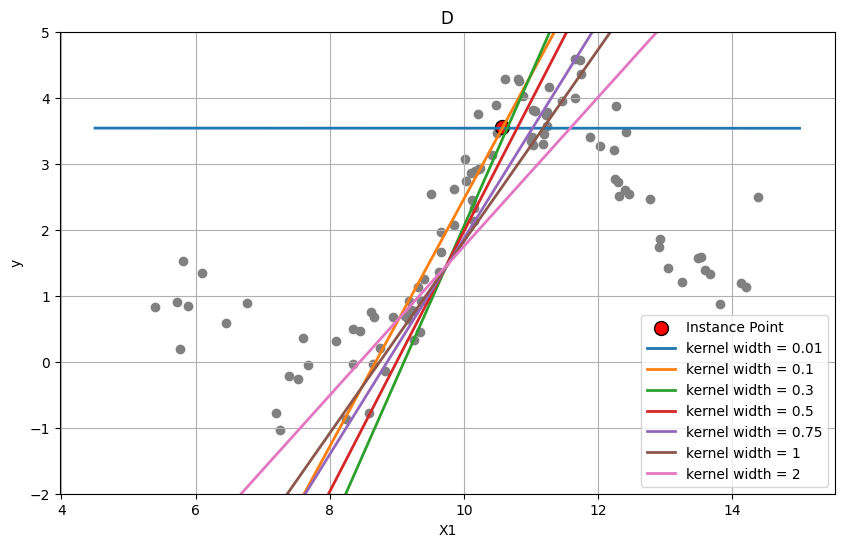

In [16]:
instance = test.iloc[10]
instance_features = instance[['X1', 'X2']].values.reshape(1, -1)
instance_target = instance['y_hat']
kernel_widths = [0.01, 0.1, 0.3, 0.5, 0.75, 1, 2]
results = {}
for kernel_width in kernel_widths:
    explainer = LimeTabularExplainer(
        train[['X1', 'X2']].values,
        mode="regression",
        feature_names=['X1', 'X2'],
        verbose=True,
        discretize_continuous=False,
        kernel_width=kernel_width
    )
    
    exp = explainer.explain_instance(
        instance_features.flatten(),
        model.predict,
        num_features=2
    )
    
    slope = exp.local_exp[1][0][1]
    y0 = exp.local_pred[0]
    results[kernel_width] = (slope, y0) 
    plt.figure(figsize=(10, 6))
plt.scatter(test['X1'], test['y_hat'],color = 'gray')
plt.scatter(
    instance['X1'], instance_target,
    color='red', s=100, label='Instance Point', edgecolor='black'
)

x_vals = np.linspace(4.5, 15, 500)
for kernel_width, (slope, y0) in results.items():
    y_vals = slope * (x_vals - instance['X1']) + y0
    plt.plot(x_vals, y_vals, linewidth=2, label=f'kernel width = {kernel_width}')

plt.ylim([-2, 5])
plt.xlabel('X1')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title("D")
plt.savefig(f"results/positive slope.png")

In [17]:
from PIL import Image
import os

image_paths = [
    "results/rf_fit.png",
    "results/piecewise_linear.png",
    "results/negative slope.png",
    "results/positive slope.png",
]

images = [Image.open(img) for img in image_paths]

width, height = images[0].size

combined_image = Image.new("RGB", (width * 2, height * 2))

positions = [
    (0, 0),
    (0, height),
    (width, 0),
    (width, height),  
]
for pos, img in zip(positions, images):
    combined_image.paste(img, pos)
    
output_path = "results/neighborhood.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
combined_image.save(output_path)